# Clinical Models

In [1]:
import warnings, pickle, os
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})

import shap
import optuna

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import plot_roc_curves, plot_pr_curves, plot_calibration_curves, plot_alert_rate, plot_confusion_matrix, evaluate_all_outcomes, evaluate_multiple, plot_calibrated_regression_coefficients, confusion_matrix_multiplot, plot_shap_features_joint, biggest_alert_rate_diff
from hyperparameter_tuning import tune_lgbm, tune_logisticregression
from utils.data_profiling import ensure_categorical_overlap, drop_exclusive_cols
from utils.shaputils import group_explanations_by_categorical
from dataset import SCIData, SCICols
%aimport utils.evaluation, hyperparameter_tuning, dataset, utils.data_profiling, utils.shaputils

In [3]:
class Notebook:
    IMAGE_DIR = "images/clinical_models_ae"
    MODEL_DIR = "models/clinical_models_ae"
    SAVE_IMAGES = True

    RUN_HYPERPARAMETERS = False
    HYPERPARAMETER_TIMEOUT = 60 * 30
    HYPERPARAMETER_TRIALS = 1000
    HYPERPARAMETER_NJOBS = 4
    HYPERPARAMETER_SCORE = "roc_auc"

    SHAP_PLOTS_MAXDISPLAY = 20
    EVAL_N_RESAMPLES = 99

    MODELS = {}
    EXPLAINERS = {}
    Y_PREDS = {}


if Notebook.SAVE_IMAGES:
    try:
        os.makedirs(Notebook.IMAGE_DIR)
    except FileExistsError:
        pass


In [4]:
from sklearn.model_selection import train_test_split

sci = SCIData(
    SCIData.quickload("data/sci_processed.h5").sort_values("AdmissionDateTime")
).mandate(SCICols.news_data_raw)

scii = (
    sci.derive_critical_event(within=1, return_subcols=True)
    .augment_shmi(onehot=True)
    .omit_redundant()
    .raw_news()
    .derive_ae_diagnosis_stems()
    .categorize()
    .onehot_encode_categories()
)

onehot_encoded_cols = scii.get_onehot_categorical_columns()

sci_train, sci_test, _, y_test_mortality, _, y_test_criticalcare = train_test_split(
    scii.drop(["DiedWithinThreshold", "CriticalCare"], axis=1),
    scii.DiedWithinThreshold,
    scii.CriticalCare,
    test_size=0.33,
    random_state=42,
    shuffle=False,
)
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

test_set_n_days = (
    sci.loc[sci_test.index].AdmissionDateTime.max()
    - sci.loc[sci_test.index].AdmissionDateTime.min()
).days



In [5]:
(X_train_lr, y_train), (X_test_lr, y_test) = (
    sci_train.impute_blood().xy(outcome="CriticalEvent", dropna=False, fillna=True),
    sci_test.impute_blood().xy(outcome="CriticalEvent", dropna=False, fillna=True),
)

(X_train_lgbm, y_train), (X_test_lgbm, y_test) = (
    sci_train.xy(outcome="CriticalEvent", dropna=False, fillna=False),
    sci_test.xy(outcome="CriticalEvent", dropna=False, fillna=False),
)

(X_train_news, _), (X_test_news, _) = (
    sci_train.xy(  # .impute_news().impute_blood()
        outcome="CriticalEvent",
        x=SCICols.news_data_raw,
        dtype=float,
        dropna=False,
        fillna=False,
    ),
    sci_test.xy(  # .impute_news().impute_blood()
        outcome="CriticalEvent",
        x=SCICols.news_data_raw,
        dtype=float,
        dropna=False,
        fillna=False,
    ),
)


In [6]:
from sklearn.metrics import precision_recall_curve, roc_curve


def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(recall - target).argmin()]

    return closest


def get_threshold_fpr(y_train, y_pred_proba, target=0.15):
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(fpr - target).argmin()]

    return closest


In [7]:
def benchmark(y_pred, y_pred_proba, modelkey, filekey, tuning=False):
    if tuning:
        y_pred = np.where(y_pred_proba > get_threshold(y_test, y_pred_proba), 1, 0)
    
    evaluate_all_outcomes(
        y_test,
        y_test_mortality,
        y_test_criticalcare,
        y_pred,
        y_pred_proba,
        modelkey,
        n_resamples=Notebook.EVAL_N_RESAMPLES,
        save=f"{Notebook.IMAGE_DIR}/eval_{filekey}.png"
        if Notebook.SAVE_IMAGES
        else None,
    )

    Notebook.Y_PREDS[modelkey] = (y_pred, y_pred_proba)


In [8]:
def restore():
    with open(f"{Notebook.MODEL_DIR}/preds.bin", "rb") as file:
        Notebook.Y_PREDS = pickle.load(file)
    with open(f"{Notebook.MODEL_DIR}/models.bin", "rb") as file:
        Notebook.MODELS = pickle.load(file)
    with open(f"{Notebook.MODEL_DIR}/explainers.bin", "rb") as file:
        Notebook.EXPLAINERS = pickle.load(file)


#restore()


# Models

## Baseline (NEWS)

,Accuracy,Precision,Recall,AP,F2 Score,AUC,AUC_CI
Baseline (NEWS),,,,,,,
Critical event,0.969003,0.283916,0.217811,0.153548,0.228449,0.801963,0.802 (0.784-0.822)
Mortality only,0.983090,0.109091,0.661017,0.174344,0.328559,0.930540,0.931 (0.894-0.961)
Critical care,0.968154,0.187413,0.161836,0.095413,0.166377,0.784928,0.785 (0.766-0.806)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


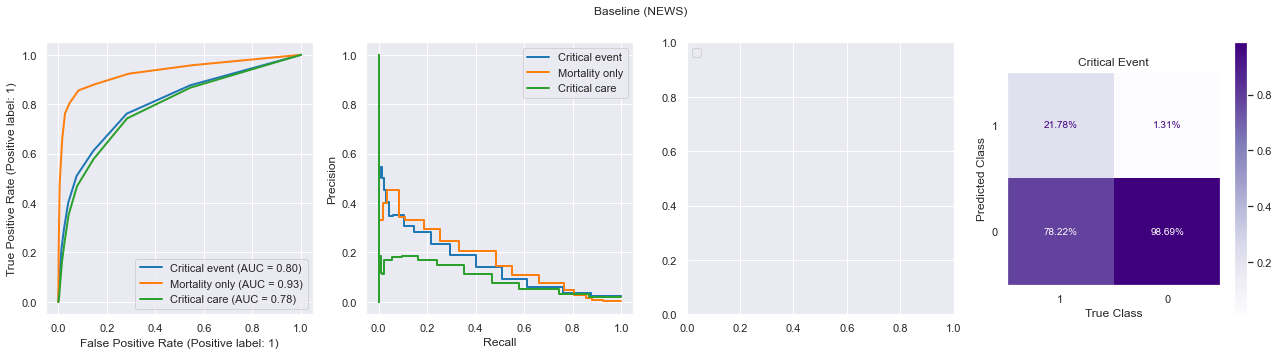

In [9]:
benchmark(
    (sci.loc[sci_test.index].NEWS_score >= 7).to_numpy(),
    sci.loc[sci_test.index].NEWS_score.to_numpy(),
    "Baseline (NEWS)",
    "news",
    tuning=False,
)


## Logistic Regression (NEWS only)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

lr_news_params = {
    "max_iter": 1000,
    "random_state": 42,
    "penalty": "elasticnet",
    "solver": "saga",
    "C": 9.9156,
    "l1_ratio": 0.8106,
    "class_weight": "balanced",
}


if Notebook.RUN_HYPERPARAMETERS:
    lr_news_params.update(
        tune_logisticregression(
            X_train_news,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS,
            score=Notebook.HYPERPARAMETER_SCORE,
        )
    )

modelkey = "NEWS-Regression"
model = CalibratedClassifierCV(
    LogisticRegression().set_params(**lr_news_params),
    cv=5,
    method="isotonic",
    n_jobs=Notebook.HYPERPARAMETER_NJOBS,
).fit(X_train_news, y_train)
Notebook.MODELS[modelkey] = model


,Accuracy,Precision,Recall,AP,F2 Score,AUC,AUC_CI
NEWS-Regression,,,,,,,
Critical event,0.573334,0.044660,0.849785,0.170982,0.184512,0.820104,0.820 (0.802-0.834)
Mortality only,0.559596,0.006203,0.932203,0.149231,0.030210,0.906209,0.906 (0.860-0.941)
Critical care,0.571136,0.039247,0.840580,0.114525,0.165352,0.808344,0.808 (0.788-0.825)


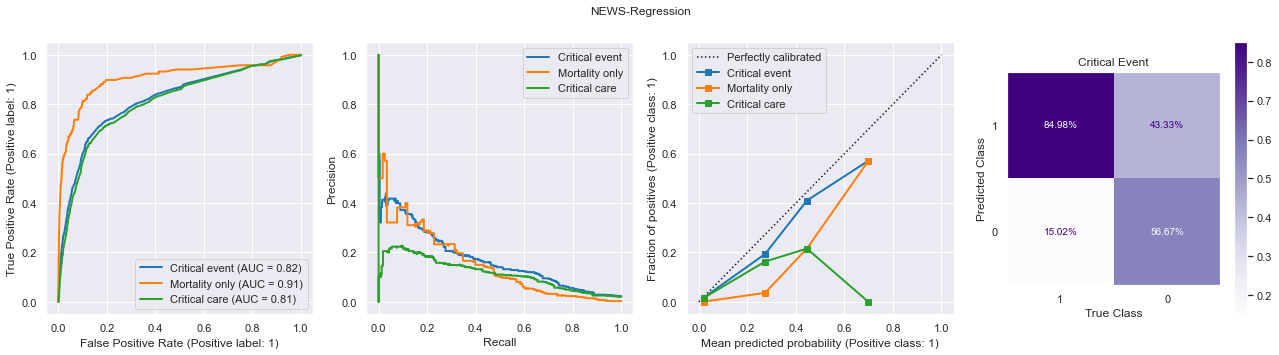

In [11]:
benchmark(
    model.predict(X_test_news),
    model.predict_proba(X_test_news)[:, 1],
    modelkey,
    "news_regression",
    tuning=True,
)



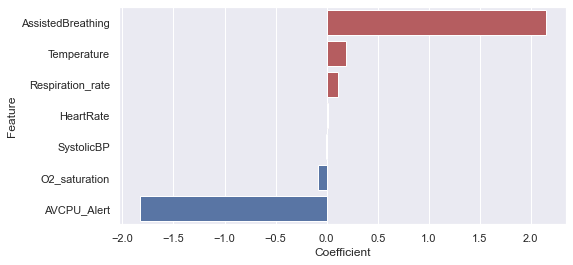

In [12]:
plot_calibrated_regression_coefficients(
    model,
    X_train_news.columns,
    topn=10,
    figsize=(8, 4),
    save=f"{Notebook.IMAGE_DIR}/logistic_regression_coef.png"
    if Notebook.SAVE_IMAGES
    else None,
)



The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

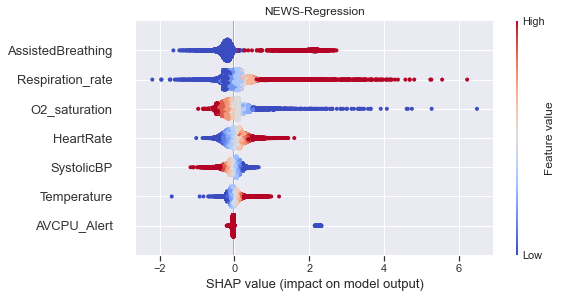

In [13]:
explainers = [
    shap.LinearExplainer(
        _.base_estimator, X_train_news, feature_perturbation="correlation_dependent"
    )(X_test_news)
    for _ in model.calibrated_classifiers_
]
shap_values = shap.Explanation(
    base_values=np.array([_.base_values for _ in explainers]).mean(axis=0),
    values=np.array([_.values for _ in explainers]).mean(axis=0),
    data=explainers[0].data,
    feature_names=X_train_news.columns,
)
Notebook.EXPLAINERS[modelkey] = shap_values

fig = shap.plots.beeswarm(
    shap_values,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    show=False,
    color=plt.get_cmap("coolwarm"),
)
plt.title("NEWS-Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_news_regression.png",
        bbox_inches="tight",
        dpi=200,
    )


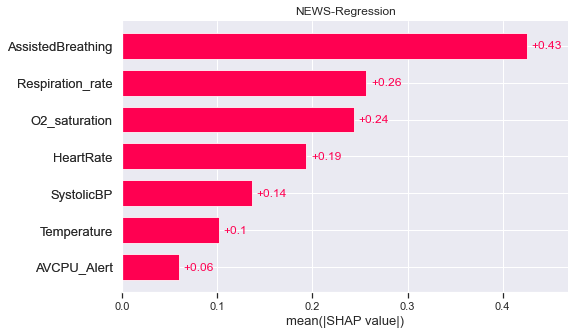

In [14]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("NEWS-Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_news_regression.png",
        bbox_inches="tight",
        dpi=200,
    )


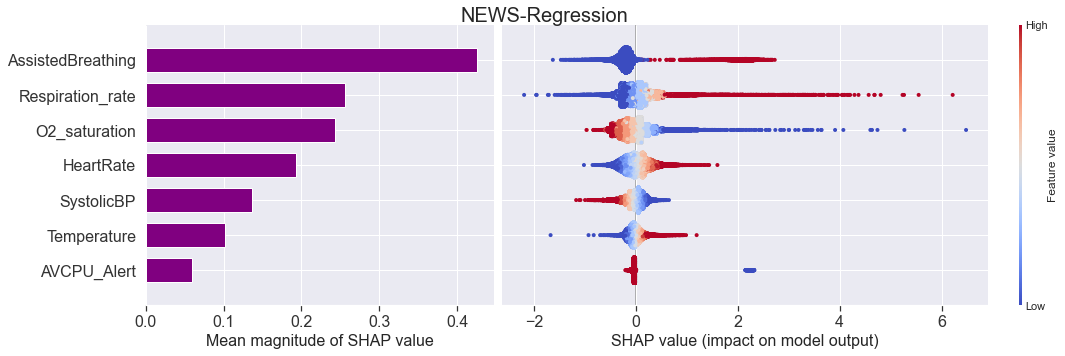

In [15]:
plot_shap_features_joint(
    shap_values,
    modelkey,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    figsize=(16, 5),
    wspace=-0.2,
    save=f"{Notebook.IMAGE_DIR}/shap_features_news_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
)


## Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

lr_params = {
    "max_iter": 5000,
    "random_state": 42,
    "penalty": "l2",
    "solver": "saga",
    "C": 5.879,
    "class_weight": "balanced",
}


if Notebook.RUN_HYPERPARAMETERS:
    lr_params.update(
        tune_logisticregression(
            X_train_lr,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS,
            score=Notebook.HYPERPARAMETER_SCORE,
        )
    )

modelkey = "Logistic Regression"
model = (
    CalibratedClassifierCV(
        LogisticRegression().set_params(
            **lr_params
        ), cv=5, method='isotonic', n_jobs=Notebook.HYPERPARAMETER_NJOBS
     )
    .fit(X_train_lr, y_train)
)
Notebook.MODELS[modelkey] = model


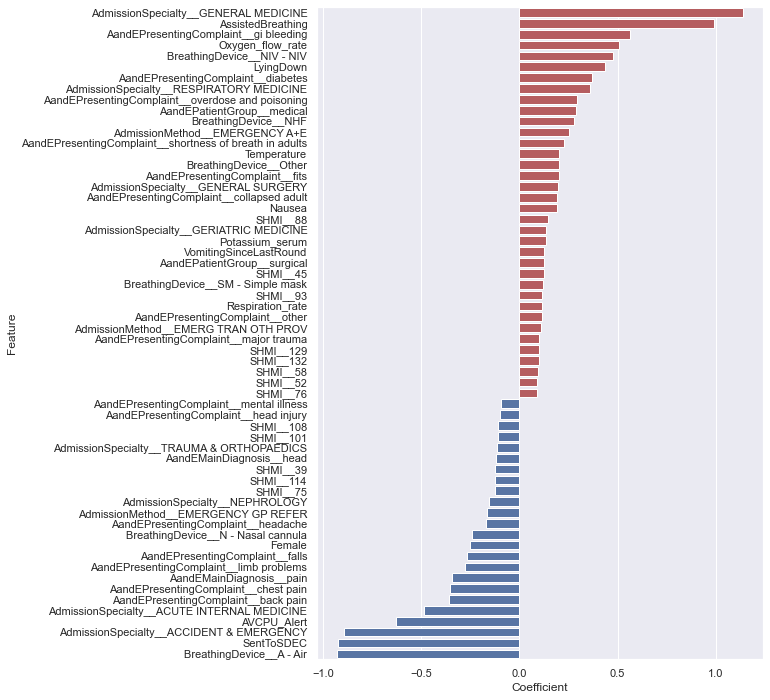

In [17]:
plot_calibrated_regression_coefficients(
    model,
    X_train_lr.columns,
    save=f"{Notebook.IMAGE_DIR}/logistic_regression_coef.png"
    if Notebook.SAVE_IMAGES
    else None,
)



,Accuracy,Precision,Recall,AP,F2 Score,AUC,AUC_CI
Logistic Regression,,,,,,,
Critical event,0.764387,0.078532,0.849785,0.326863,0.286686,0.898169,0.898 (0.886-0.907)
Mortality only,0.750450,0.010511,0.898305,0.106454,0.050204,0.910254,0.910 (0.871-0.947)
Critical care,0.762389,0.069410,0.845411,0.260800,0.261253,0.895691,0.896 (0.884-0.907)


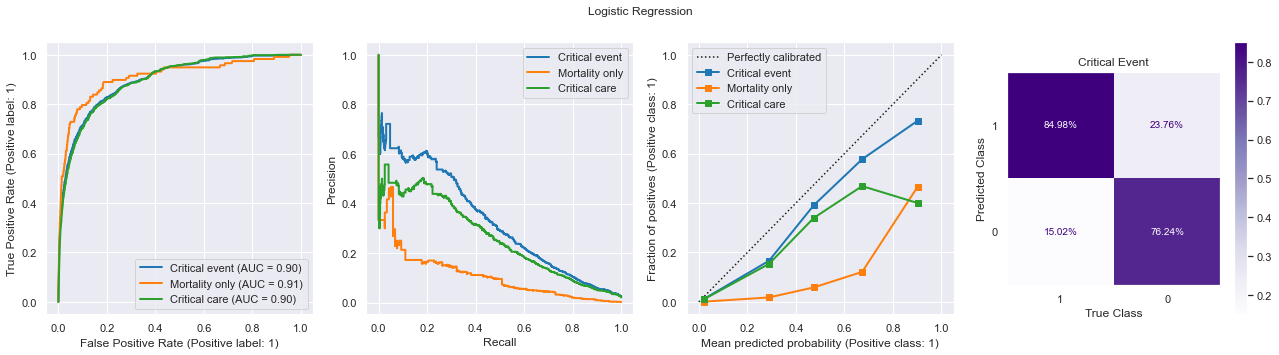

In [18]:
benchmark(
    model.predict(X_test_lr),
    model.predict_proba(X_test_lr)[:, 1],
    modelkey,
    "logistic_regression",
    tuning=True,
)



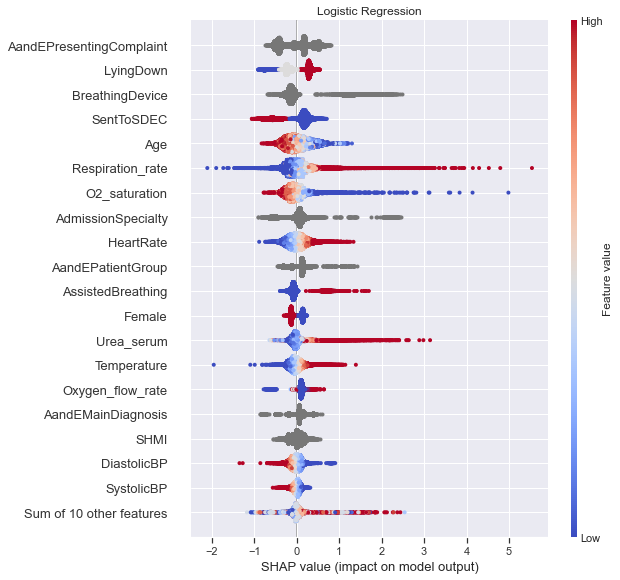

In [20]:
explainers = [
    shap.LinearExplainer(
        _.base_estimator, X_train_lr, feature_perturbation='correlation_dependent'
    )(X_test_lr)
    for _ in model.calibrated_classifiers_
]
shap_values = shap.Explanation(
    base_values=np.array([_.base_values for _ in explainers]).mean(axis=0),
    values=np.array([_.values for _ in explainers]).mean(axis=0),
    data=explainers[0].data,
    feature_names=X_train_lr.columns,
)
Notebook.EXPLAINERS[modelkey] = shap_values
shap_values = group_explanations_by_categorical(
    shap_values, X_test_lr, onehot_encoded_cols
)

fig = shap.plots.beeswarm(
    shap_values,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    show=False,
    color=plt.get_cmap("coolwarm"),
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression.png",
        bbox_inches="tight",
        dpi=200,
    )


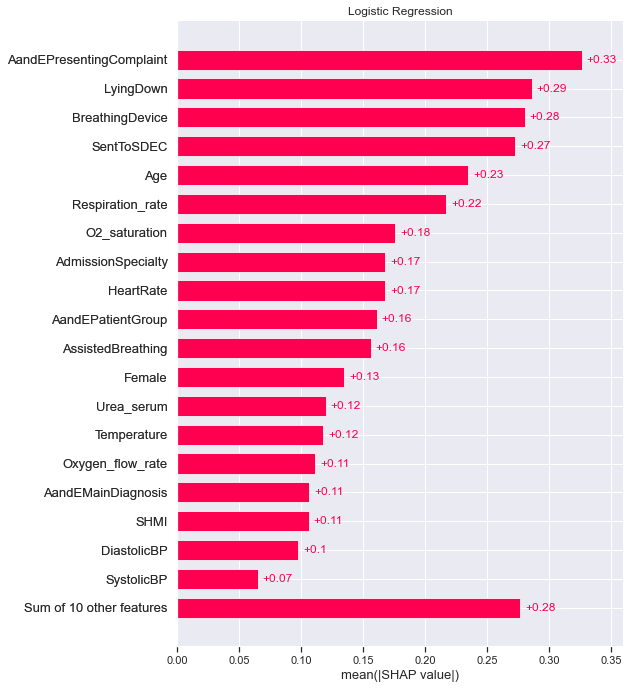

In [21]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logsitic_regression.png",
        bbox_inches="tight",
        dpi=200,
    )


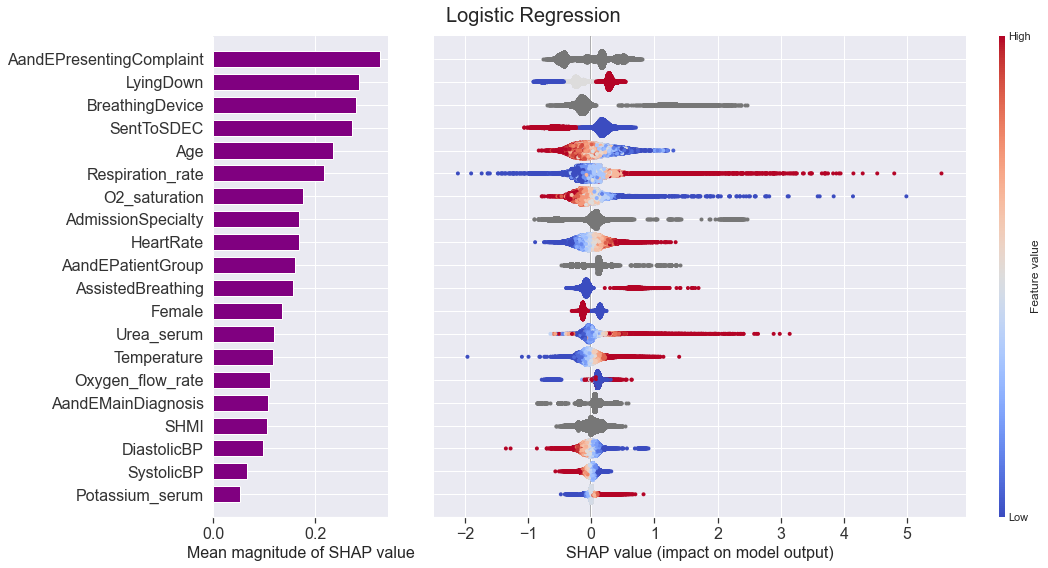

In [22]:
plot_shap_features_joint(
    shap_values,
    modelkey,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    figsize=(16, 8),
    wspace=-0.3,
    save=f"{Notebook.IMAGE_DIR}/shap_features_logistic_regression.png"
    if Notebook.SAVE_IMAGES
    else None,
)


## LightGBM

In [23]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibratedClassifierCV

lgbm_params = {
    "LGBM__objective": "binary",
    "LGBM__verbose_eval": -1,
    "LGBM__random_state": 42,
    "LGBM__metrics": ["l2", "auc"],
    "LGBM__boosting_type": "gbdt",
    "LGBM__is_unbalance": True,
    "LGBM__n_jobs": 1,
    "LGBM__feature_pre_filter": False,
    "LGBM__lambda_l1": 1.793e-3,
    "LGBM__lambda_l2": 6.2266e-4,
    "LGBM__num_leaves": 14,
    "LGBM__feature_fraction": 0.41188,
    "LGBM__bagging_fraction": 0.97156,
    "LGBM__bagging_freq": 1,
    "LGBM__min_child_samples": 6,
    "IMB__sampling_strategy": 0.104,
}

if Notebook.RUN_HYPERPARAMETERS:
    lgbm_params.update(
        tune_lgbm(
            X_train_lr,
            y_train,
            None,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS,
            score=Notebook.HYPERPARAMETER_SCORE,
        )
    )

modelkey = "LightGBM"
model = CalibratedClassifierCV(
    ImbPipeline(
        steps=[("IMB", RandomUnderSampler()), ("LGBM", LGBMClassifier())]
    ).set_params(**lgbm_params),
    cv=5,
    method="isotonic",
    n_jobs=Notebook.HYPERPARAMETER_NJOBS,
).fit(X_train_lgbm, y_train)

Notebook.MODELS[modelkey] = model


,Accuracy,Precision,Recall,AP,F2 Score,AUC,AUC_CI
LightGBM,,,,,,,
Critical event,0.832126,0.107419,0.849785,0.539028,0.356725,0.926987,0.927 (0.917-0.937)
Mortality only,0.818189,0.014377,0.898305,0.050701,0.067559,0.929315,0.929 (0.899-0.954)
Critical care,0.830128,0.094941,0.845411,0.517762,0.327562,0.925357,0.925 (0.916-0.936)


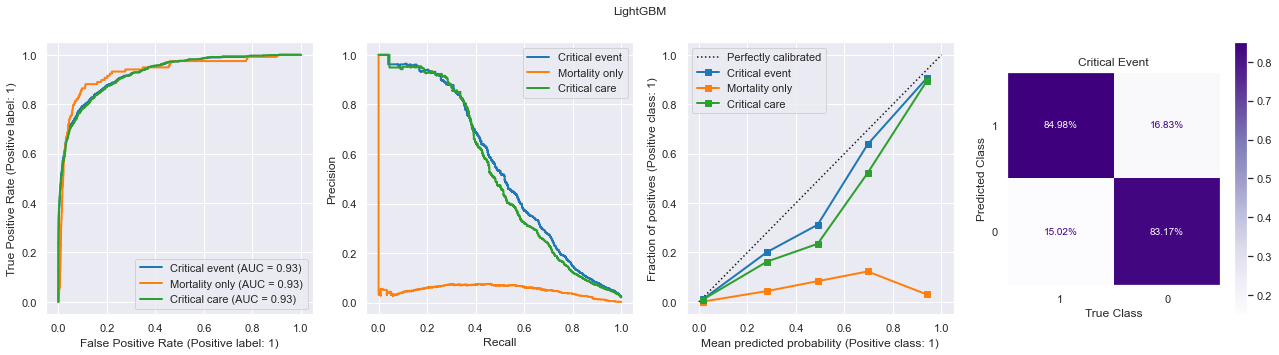

In [24]:
benchmark(
    model.predict(X_test_lgbm),
    model.predict_proba(X_test_lgbm)[:, 1],
    modelkey,
    "lightgbm",
    tuning=True,
)



In [25]:
# cols = X_train_lgbm.columns.to_list()
# cols = [
#     _.replace("AdmissionSpecialty", "AdmSpecialty")
#     .replace("EMERGENCY A+E", "A&E")
#     .replace("ACCIDENT & EMERGENCY", "A&E")
#     .replace("ACUTE INTERNAL MEDICINE", "ACUTE")
#     .replace("GENERAL MEDICINE", "MEDICINE")
#     .replace("AdmissionMethod", "Pathway")
#     .replace("AdmittedFromSDEC", "SentToSDEC")
#     for _ in cols
# ]


In [26]:
explainers = [
    shap.TreeExplainer(_.base_estimator["LGBM"])(X_test_lgbm)
    for _ in model.calibrated_classifiers_
]
shap_values = shap.Explanation(
    base_values=np.array([_.base_values for _ in explainers]).mean(axis=0),
    values=np.array([_.values for _ in explainers]).mean(axis=0),
    data=explainers[0].data,
    feature_names=X_train_lgbm.columns,
)
Notebook.EXPLAINERS[modelkey] = shap_values
shap_values = group_explanations_by_categorical(
    shap_values, X_test_lgbm, onehot_encoded_cols
)


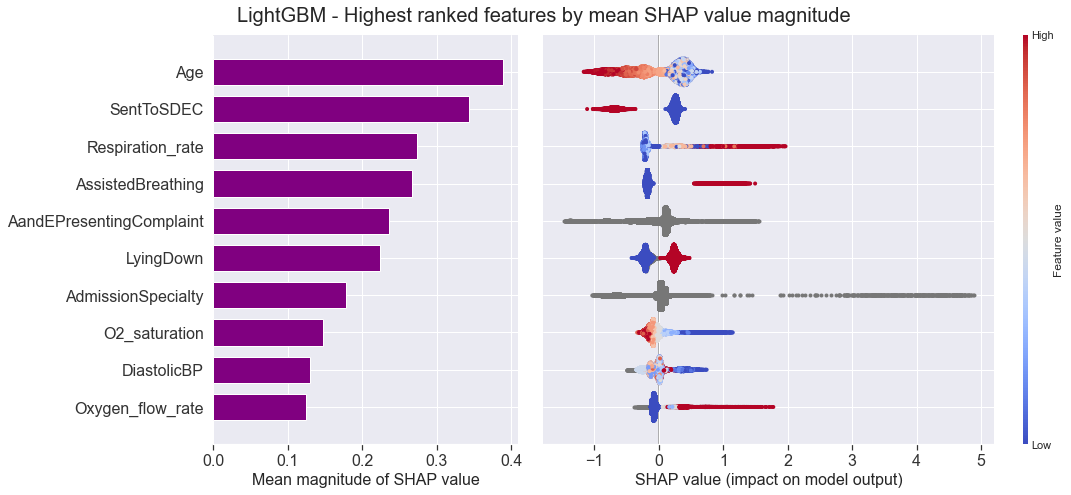

In [45]:
plot_shap_features_joint(
    shap_values,
    "LightGBM - Highest ranked features by mean SHAP value magnitude",
    max_display=10,
    figsize=(16, 7),
    wspace=-0.185,
    bar_aspect=0.050,
    topadjust=0.925,
    save=f"{Notebook.IMAGE_DIR}/shap_features_lightgbm_10.png"
    if Notebook.SAVE_IMAGES
    else None,
   # save_format="svg",
)


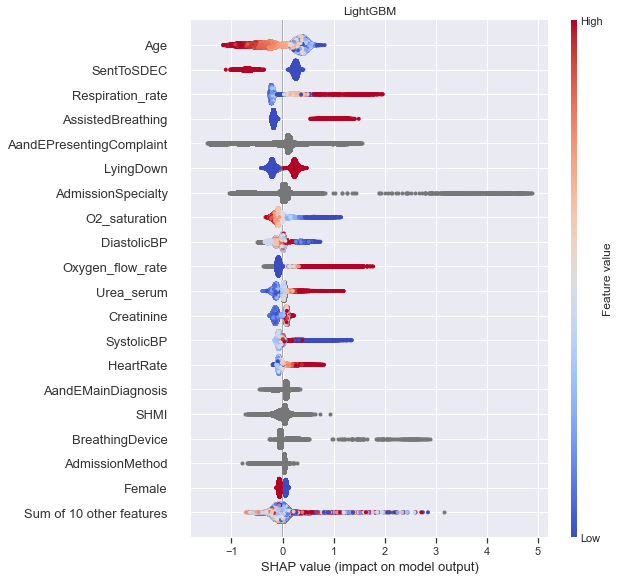

In [28]:
fig = shap.plots.beeswarm(
    shap_values,
    max_display=Notebook.SHAP_PLOTS_MAXDISPLAY,
    show=False,
    color=plt.get_cmap("coolwarm"),
)
plt.title("LightGBM")
if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_lightgbm.png", bbox_inches="tight", dpi=200
    )


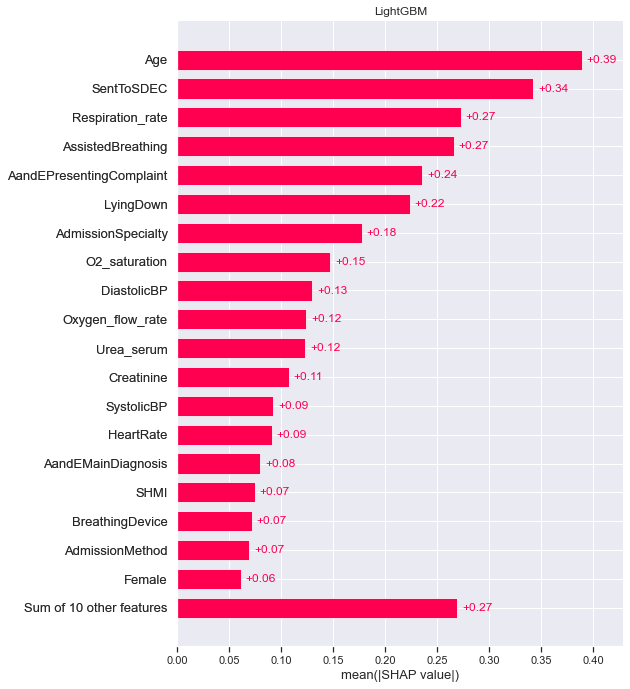

In [29]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_lightgbm.png", bbox_inches="tight", dpi=200
    )


# Comparisons

In [30]:
Notebook.Y_PREDS = dict(reversed(Notebook.Y_PREDS.items()))


,Accuracy,Precision,Recall,AP,F2 Score,AUC,AUC_CI
Model,,,,,,,
LightGBM,0.832126,0.107419,0.849785,0.539028,0.356725,0.926987,0.927 (0.917-0.937)
Logistic Regression,0.764387,0.078532,0.849785,0.326863,0.286686,0.898169,0.898 (0.886-0.907)
NEWS-Regression,0.573334,0.044660,0.849785,0.170982,0.184512,0.820104,0.820 (0.802-0.834)
Baseline (NEWS),0.969003,0.283916,0.217811,0.153548,0.228449,0.801963,0.802 (0.784-0.822)


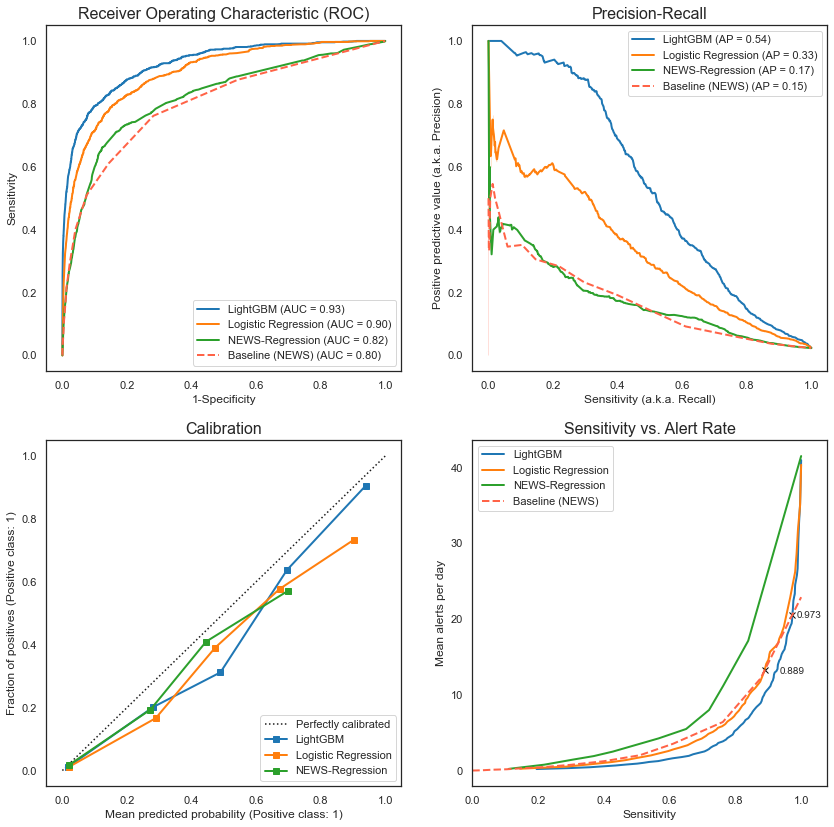

In [32]:
from utils.evaluation import evaluate_multiple

evaluate_multiple(
    y_test,
    Notebook.Y_PREDS,
    news_modelkey="Baseline (NEWS)",
    save=f"{Notebook.IMAGE_DIR}/combined_curves.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
    alert_rate_n_days=test_set_n_days,
)



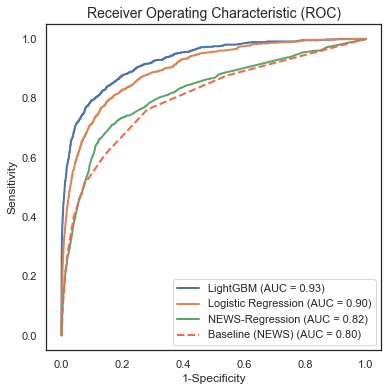

In [51]:
plot_roc_curves(
    y_test,
    Notebook.Y_PREDS,
    baseline_key="Baseline (NEWS)",
    save=f"{Notebook.IMAGE_DIR}/combined_roc.png" if Notebook.SAVE_IMAGES else None,
    #save_format="svg",
)



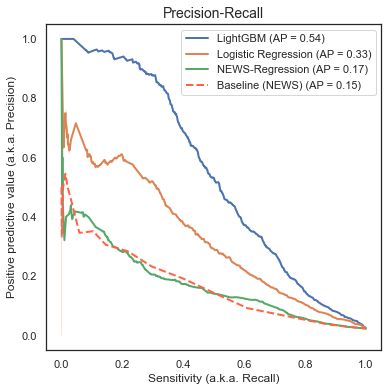

In [50]:
plot_pr_curves(
    y_test,
    Notebook.Y_PREDS,
    baseline_key="Baseline (NEWS)",
    save=f"{Notebook.IMAGE_DIR}/combined_pr.png" if Notebook.SAVE_IMAGES else None,
    #save_format="svg",
)



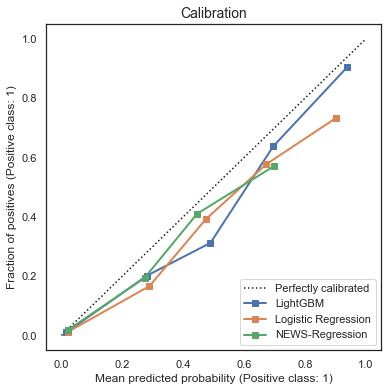

In [48]:
plot_calibration_curves(
    y_test,
    Notebook.Y_PREDS,
    save=f"{Notebook.IMAGE_DIR}/combined_calibration.png"
    if Notebook.SAVE_IMAGES
    else None,
   # save_format="svg",
)



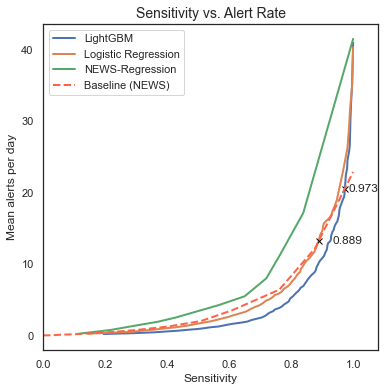

In [49]:
plot_alert_rate(
    y_test,
    Notebook.Y_PREDS,
    test_set_n_days,
    baseline_key="Baseline (NEWS)",
    save=f"{Notebook.IMAGE_DIR}/combined_alert_rate.png"
    if Notebook.SAVE_IMAGES
    else None,
   # save_format="svg",
)



In [37]:
sensitivity, news_rate, lgbm_rate = biggest_alert_rate_diff(
    y_test,
    Notebook.Y_PREDS["Baseline (NEWS)"][1],
    Notebook.Y_PREDS["LightGBM"][1],
    test_set_n_days,
)
print(
    f"At sensitivity ~{sensitivity:.3f}: NEWS Alert rate: {news_rate:.3f}, LGBM Alert rate: {lgbm_rate:.3f} -> {100-(lgbm_rate*100/news_rate):.3f}% less"
)



At sensitivity ~0.877: NEWS Alert rate: 12.165, LGBM Alert rate: 8.944 -> 26.477% less


In [38]:
retune = lambda y_pred_proba: (
    np.where(
        y_pred_proba > get_threshold_fpr(y_test, y_pred_proba, target=0.0131), 1, 0
    ),
    y_pred_proba,
)
# retuned = {
#     key: (np.where(y_pred_proba > get_threshold_fpr(y_test, y_pred_proba, target=0.1379), 1, 0), y_pred_proba)
#     for key, (_, y_pred_proba) in Notebook.Y_PREDS.items() if key != "Baseline (NEWS)"
# }
retuned = {}
retuned["Baseline (NEWS ≥ 7)"] = Notebook.Y_PREDS["Baseline (NEWS)"]
retuned["NEWS-Regression"] = retune(Notebook.Y_PREDS["NEWS-Regression"][1])
retuned['Logistic Regression'] = retune(Notebook.Y_PREDS['Logistic Regression'][1])
retuned["LightGBM"] = retune(Notebook.Y_PREDS["LightGBM"][1])



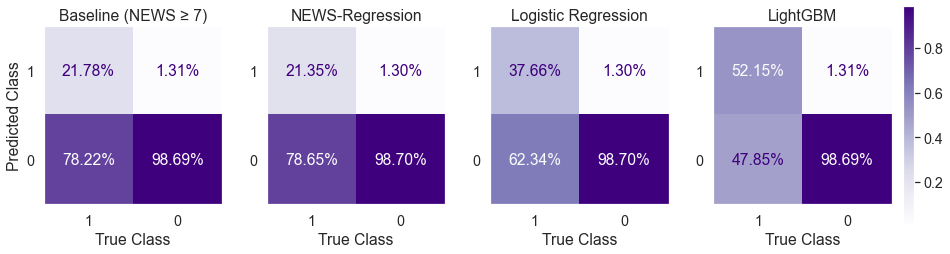

In [39]:
confusion_matrix_multiplot(
    y_test, retuned, save=f"{Notebook.IMAGE_DIR}/combined_matrices_3.png"
)



## SHAP

In [40]:
explainers = Notebook.EXPLAINERS.copy()
for _ in ["LightGBM", 'Logistic Regression']:
    explainers[_] = group_explanations_by_categorical(
        explainers[_], X_test_lr, onehot_encoded_cols
    )



In [46]:
def patient_force_plots(patient):
    patient_idx = X_test_lr.index.get_loc(patient)

    explanations = {
        modelkey: shap_values[patient_idx]
        for modelkey, shap_values in explainers.items()
    }

    sns.set_style("white")
    plt.rc("axes", titlesize=16)
    for modelkey, explanation in explanations.items():

        fig = shap.plots.force(
            explanation,
            matplotlib=True,
            contribution_threshold=0.05,
            show=False,
            text_rotation=15,
        )

        plt.title(modelkey)
        display(fig)

        if Notebook.SAVE_IMAGES:
            plt.savefig(
                f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.png",
                bbox_inches="tight",
               # format="svg",
            )

        plt.clf()

    sns.set_style("darkgrid")


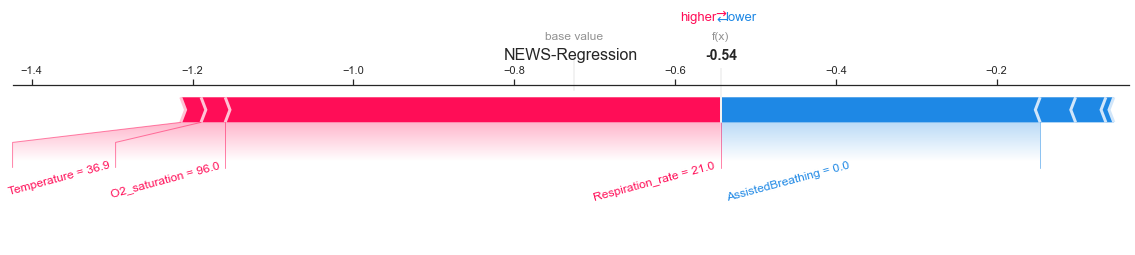

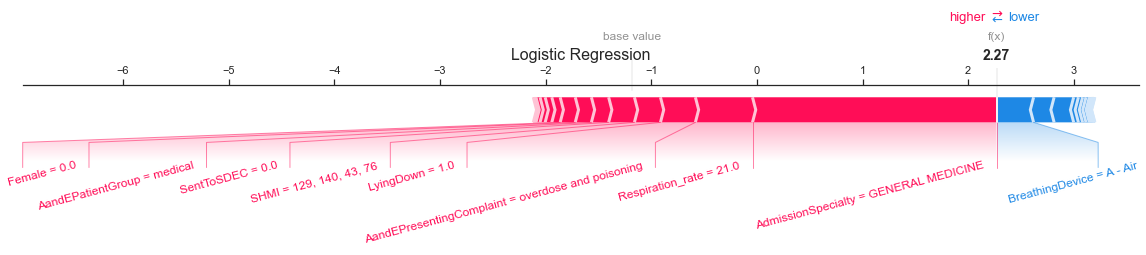

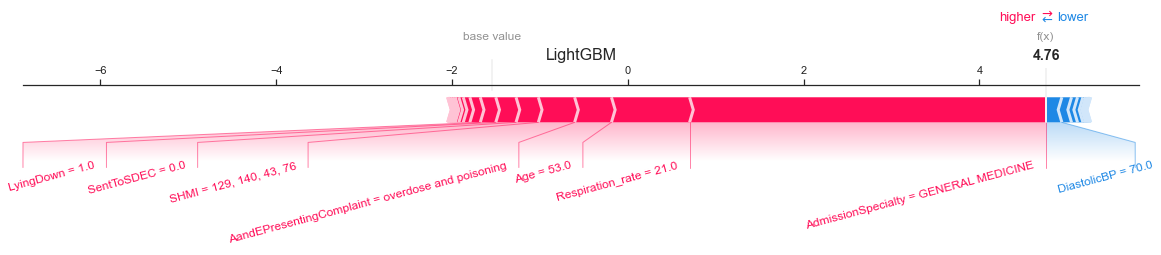

<Figure size 1440x216 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

In [47]:
preds_df = (
    pd.DataFrame({key: val[0] for key, val in Notebook.Y_PREDS.items()})
    .astype(bool)
    .set_index(y_test.index)
)
candidate_mask = (
    preds_df["LightGBM"]
    & ~preds_df["Baseline (NEWS)"]
    & y_test.astype(bool)
    & (X_test_lr.AssistedBreathing == 0)
)
candidates = preds_df[candidate_mask].index

patient_force_plots(55599)


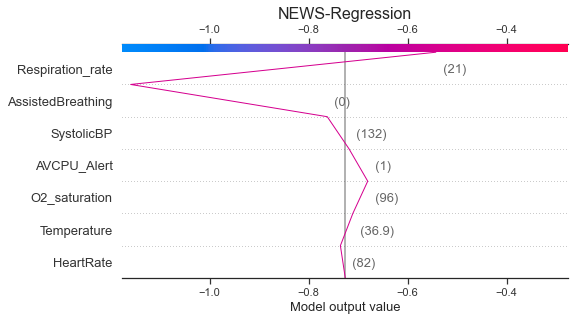

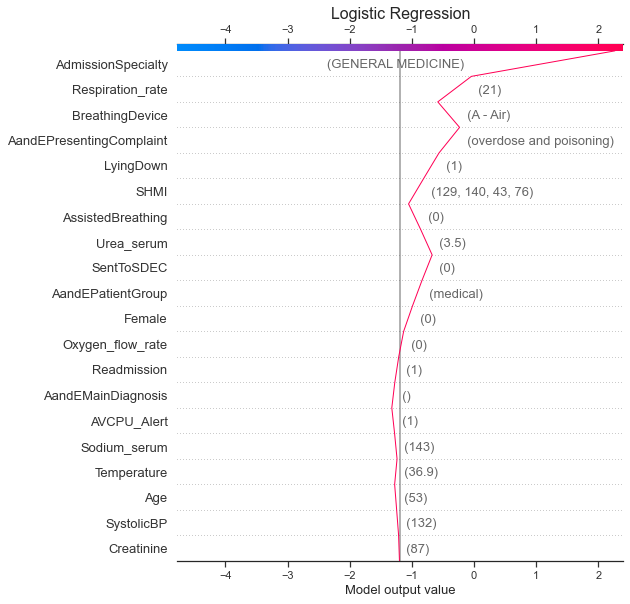

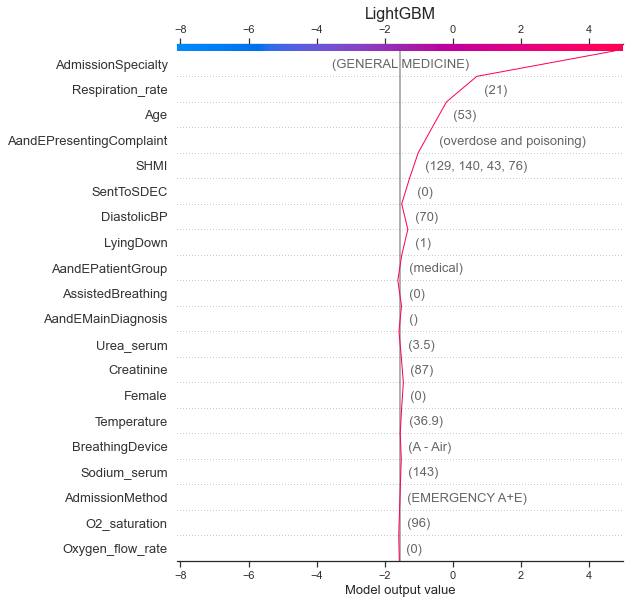

In [43]:
def patient_decision_plots(patient):
    patient_idx = X_test_lr.index.get_loc(patient)

    explanations = {
        modelkey: _[patient_idx]
        for modelkey, _ in explainers.items()
    }

    sns.set_style("white")
    plt.rc("axes", titlesize=16)
    for modelkey, explanation in explanations.items():

        fig = plt.figure()
        shap.decision_plot(
            explanation.base_values,
            explanation.values,
            explanation.data,
            explanation.feature_names,
            show=False,
        )
        plt.title(modelkey)

        if Notebook.SAVE_IMAGES:
            plt.savefig(
                f"{Notebook.IMAGE_DIR}/long_force_plot_{modelkey.replace(' ','')}.png",
                bbox_inches="tight",
                dpi=200,
            )

patient_decision_plots(55599)


In [44]:
def save():
    try:
        os.makedirs(Notebook.MODEL_DIR)
    except FileExistsError:
        pass

    with open(f"{Notebook.MODEL_DIR}/preds.bin", "wb") as file:
       pickle.dump(Notebook.Y_PREDS, file)
    with open(f"{Notebook.MODEL_DIR}/models.bin", "wb") as file:
        pickle.dump(Notebook.MODELS, file)
    with open(f"{Notebook.MODEL_DIR}/explainers.bin", "wb") as file:
        pickle.dump(Notebook.EXPLAINERS, file)


save()
